# Mini-projet n°2 - Conditional VAEs

L'objectif de ce projet est de définir et entraîner un Conditional VAE (CVAE). Nous allons tout d'abord définir ce qu'est un CVAE et la différence avec un VAE, puis définir et entraîner un CVAE sur le dataset Fashin-MNIST.

## Définition d'un CVAE

### Définition d'un VAE

Un Variational AutoEncoder (VAE) est un autoencoder qui cherche à apprendre la distribution des données $x$, en introduisant des variables latentes $z$. produit une distribution de probabilité dans l'espace latent. La partie encodeur va apprendre $q(z|x)$, soit la distribution de $z$, la forme dans l'espace latent, en sachant $x$, la donnée d'entrée. En réalité, on va plutôt poser $z=\mu(x) + \sigma(x) \epsilon$, avec $\epsilon \sim \mathcal{N}(0,1)$. Ainsi, l'encodeur apprendra plutôt l'espérance $\mu$ et le log de l'écart-type $\log(\sigma)$. A l'inverse, la partie décodeur va apprendre $p(x|z)$, soit la distriubtion de la donnée d'entrée $x$ en connaissant sa place dans l'espace. 

La fonction perte utilisée pour un VAE est :
$$Loss =  L(x, x') + \sum_{j=1}^{m} KL( q(z_j | x) \Vert \, p(z_j))$$

avec $L$ une fonction perte de reconstruction telle que la MSE ou BCE, qui va permettre au VAE de recréer des données de sorties proches des données initiales; et $KL : (f, f') \to KL(f, f')$ la divergence de Kullback-Leibler, qui va forcer l'espace latent à suivre une distribution donnée $p(z)$. On suppose en général que $p(z) \sim \mathcal{N}(0,1)$.

On peut ensuite échantillonner un point de la distribution de probabilité de l'espace latent afin de générer de nouvelles données grâce au décodeur. 

Voici une image pour mieux visualiser :

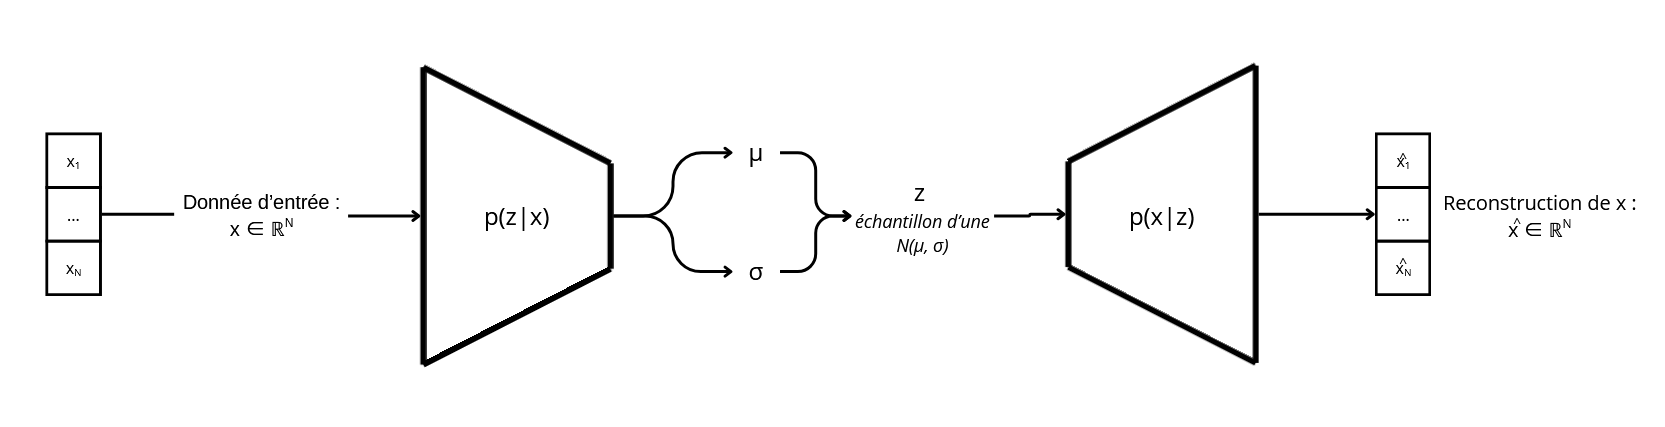

### Définition d'un CVAE

Le CVAE est une extension du VAE du point de vue de la structure. La différence réside dans le fait qu'on ajoute un deuxième conditionnement, $y$ qui donne des informations sur le contexte de la donnée d'entrée $x$. Par exemple, $x$ peut être une image et $y$ son label. D'une part, l'encodeur va apprendre $q(z|x,y)$, avec $z$ la représentation de $x$ dans l'espace latent. De la même manière qu'un VAE, encore une fois l'encodeur va apprendre $\mu(x,y)$ et $\sigma(x,y)$ de la distribution. De l'autre part, le décodeur va apprendre $p(x|z,y)$ : on trouve donc à la fois la représentation dans l'espace latent $z$ mais aussi le label $y$ dans l'entrée du décodeur. 

La fonction perte utilisée pour un CVAE est semblable à la fonction perte utilisée pour un VAE : 
$$Loss =  L(x, x') + \sum_{j=1}^{m} KL( q(z_j | x, y) \Vert \, p(z_j | y))$$
avec $L$ une fonction perte de reconstruction (MSE ou BCE), pour que les données en sortie soient proches des données d'entrée, et $KL$ la divergence Kullback-Leibler. De plus, on suppose que la distribution de l'espace latent est de la forme $p(z | y) \sim \mathcal{N}(0,1)$.

Après avoir entraîné le modèle, on peut créer de nouvelles données d'une classe spécifique en donnant $y$ le label de la donnée que l'on souhaite créer, et en échantillonnant un point de la distribution de l'espace latent (supposée normale). Alors que pour un VAE l'espace latent va décrire les différences entre les classes, l'espace latent d'un CVAE va décrire la différence entre les objets d'une même classe. Ainsi, en donnant un même échantillon de l'espace latent $z$ mais un label $y$ différent, le décodeur va fournir des images des différentes classes demandées, mais avec un même style car $z$ était similaire. 

Voici une image issue afin de mieux visualiser.


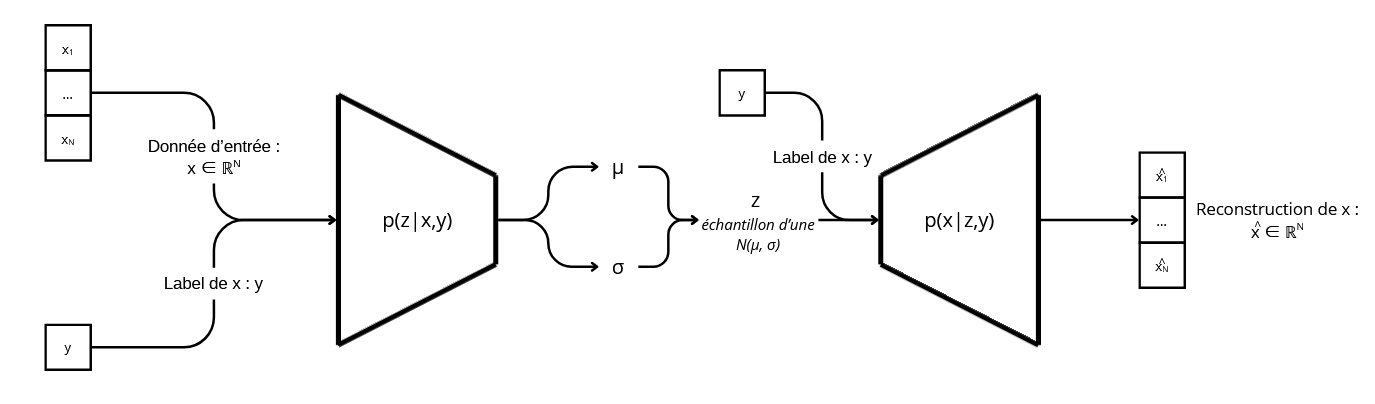

## Création du CVAE

In [1]:
# Maths et Utils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/helleu/.conda/envs/HDDLtorch/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Importation des données

In [ ]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Remarque : la taille du batch est de $128$, ce qui est une valeur usuelle et permet un compromis entre vitesse et stabilité. 

In [5]:
img, label = train_dataset[0]
print("Image shape :", img.shape)

classes = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4: 'Coat',
    5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot' }

print(classes)


Image shape : torch.Size([1, 28, 28])
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


Le jeu de données Fashion MNIST comporte 70 000 images labellisées de taille $28 \times 28$.
Il y a 10 classes différentes, qui représentent différentes vêtements : 
- T-shirt 
- Pantlons
- Pull
- Robes
- Manteau
- Sandales
- Chemises
- Chaussures / baskets
- Sac
- Bottes

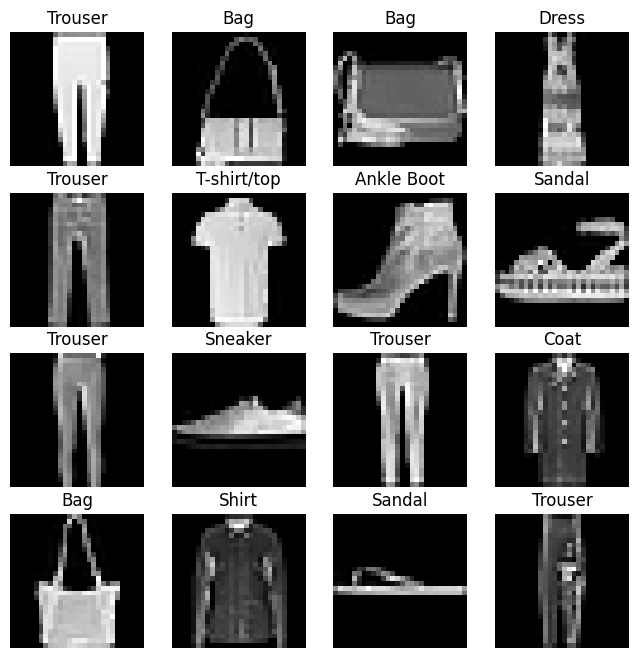

In [6]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(classes[labels[i].item()])
    plt.axis("off")
plt.show()

In [7]:
labels = [label for _, label in train_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu d'apprentissage :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu d'apprentissage :
- Ankle Boot : 6000
- T-shirt/top : 6000
- Dress : 6000
- Pullover : 6000
- Sneaker : 6000
- Sandal : 6000
- Trouser : 6000
- Shirt : 6000
- Coat : 6000
- Bag : 6000


In [8]:
labels = [label for _, label in test_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu de test :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu de test :
- Ankle Boot : 1000
- Pullover : 1000
- Trouser : 1000
- Shirt : 1000
- Coat : 1000
- Sandal : 1000
- Sneaker : 1000
- Dress : 1000
- Bag : 1000
- T-shirt/top : 1000


### Défintion du CVAE

Nous nous sommes inspirés du TP sur les VAE pour la structure du CVAE, avec quelques adaptations. 

L'encodeur est un réseau convolutionnel (CNN), car on travaille avec des images comme données d'entrée : les CNN sont plus adaptés pour travailler avec des images qu'un réseau de neuronnes classique (informations spatiales conservées et moins de paramètres). Nous avons choisi 3 blocs avec cette structure :
- une couche de convolution, avec des filtres de taille $3 \times 3$ (32 filtres pour la première couche, 34 pour la deuxième et 128 pour la troisième).
- une couche de Batch Normalization, afin de normaliser les canaux. Cela permet d'avoir des gradients plus stables, et donc une convergence plus rapide. 
- une fonction ReLU, afin d'ajouter de la non linéarité et de capturer les phénomènes plus complexes. C'est une fonction simple et peu couteuse, c'est pourquoi nous l'avons choisie. 
De plus, pour chaque couche de convolution, nous avons choisi un padding de $1$, afin de ne pas perdre trop d'informations sur les bords. De plus, nous avons pris un stride de $2$ afin de réduire la dimension de la sortie : c'est un rôle similaire à une couche de MaxPooling, mais qui apprend mieux le comportement de l'image. Ainsi, en sortie de ce petit réseau nous avons une image de $128$ channels de taille $4 \times 4$. 

Pour finir, nous avons une couche Flatten afin de transformer nos images en un vecteur, utile pour les couches suivantes. 
Cette architecture n'est pas très complexe (3 couches uniquement) mais suffisante pour des petites tailles d'images, comme MNIST ($28 \times 28$). 

Ensuite, nous avons choisi une stratégie de one-hot encoding pour faire passer le label au décodeur. Une stratégie d'embedding aurait aussi pu être faite. Cela permet que la classe (valeur discrète) soit transformée en une représentation plus dense, apprise au cours de l'apprentissage du réseau. Cette stratégie permet plus de souplesse, et d'apprendre les liens, s'il y en a, entre les différentes classes. Cependant, étant donné qu'il y a peu de classes ici (10), une stratégie one-hot suffit. 

Grâce à deux couches linéaires, le réseau apprend ensuite les paramètres de la distribution dans l'espace latent : $\mu$ et $log(\sigma)$.

Nous avons ensuite le décodeur, qui se compose de deux blocs avec les couches suivantes : 
- une couche de déconvolution, afin d'agrandir l'image et de réduire le nombre de channels pour obtenir en sortie une image de même taille qu'en entrée.
- une couche de Batch Normalization, afin de normaliser les canaux.
- une fonction ReLU, pour ajouter de la non-linéarité.
On rajoute ensuite une dernière couche de déconvolution, puis une Sigmoid, pour que la valeur des pixels soient comprises entre 0 et 1. 


In [51]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )

        self.flatten_size = 128 * 4 * 4

        # Latent space (with concatenated condition)
        self.fc_mu = nn.Linear(self.flatten_size + num_classes, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size + num_classes, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + num_classes, 4 * 4 * 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def to_one_hot(self, y):
        return F.one_hot(y, num_classes = self.num_classes).float()
    
    def encode(self, x, y):
        x = self.encoder(x)
        y_onehot = self.to_one_hot(y)
        # Concatenate condition with encoded input
        x = torch.cat([x, y_onehot], dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_onehot = self.to_one_hot(y)
        # Concatenate condition with latent vector
        z = torch.cat([z, y_onehot], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x, y):
        mu, log_var = self.encode(x, y)
        z = self.sample(mu, log_var)
        return self.decode(z, y), mu, log_var

In [52]:
def loss_function(recon_x, x, mu, logvar, beta = 1) :
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD, BCE, beta*KLD

## Entraînement du CVAE

Nous allons créer 3 CVAE différents, avec différentes valeurs de $\beta$ : $1$, $10$ et $50$. Ainsi, on pourra comparer les résultats et voir l'influence de ce paramètre sur le réseau.

Pour la dimension de l'espace latent, nous avons choisi $2$ : cela permet de visualiser plus facilement l'espace latent ensuite. De plus, pour des petites images simples comme MNSIT, il n'est pas nécessaire d'avoir un espace latent de grande dimension. 

Le larning rate choisi est de $1 \times 10^{-3}$, ce qui est le learning rate standard avec l'optimiseur Adam. Pour finir, le nombre d'epochs choisi est de $40$ : c'est suffisant pour ces petites images (voir fonction perte qui converge). 

In [53]:
# Paramètres
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta_1 = 1
beta_2 = 10
beta_3 = 50

In [54]:
def plot_loss(nb_epochs, loss_list, bce_list, b_kld_list) :
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, nb_epochs + 1)
    # Affichage de la loss
    axes[0].plot(epochs, loss_list, label='Total Loss', color='blue')
    axes[0].set_title('Total Loss over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Affichage de la BCE
    axes[1].plot(epochs, bce_list, label='Binary Cross-Entropy', color='orange')
    axes[1].set_title('Binary Cross-Entropy over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('BCE Loss')
    axes[1].legend()
    axes[1].grid(True)

    # Affichage de la KL Divergence
    axes[2].plot(epochs, b_kld_list, label='beta * KL Divergence', color='green')
    axes[2].set_title('beta * KL Divergence over Epochs')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('beta * KL Loss')
    axes[2].legend()
    axes[2].grid(True)
    plt.tight_layout()
    plt.show()
    

In [55]:
def def_train_cvae(beta, latent_dim = 2, learning_rate = 1e-3, epochs = epochs) :
    cvae = ConditionalVAE(latent_dim=latent_dim, num_classes=10)
    cvae.to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

    loss_list = []
    bce_list = []
    b_kld_list = []
        
    for epoch in range(epochs):
        cvae.train()
        all_loss = 0.0
        bce_loss = 0.0
        b_kld_loss = 0.0
    
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, labels)
            loss, bce, b_kld = loss_function(recon_batch, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            
            all_loss += loss.item()
            bce_loss += bce.item()
            b_kld_loss += b_kld.item()
        
        # Moyennes par epoch
        nb_batch = len(train_loader.dataset)
        loss_list.append(all_loss / nb_batch)
        bce_list.append(bce_loss / nb_batch)
        b_kld_list.append(b_kld_loss / nb_batch)
    
    # Affichage des courbes de perte
    plot_loss(epochs, loss_list, bce_list, b_kld_list)
    
    return cvae

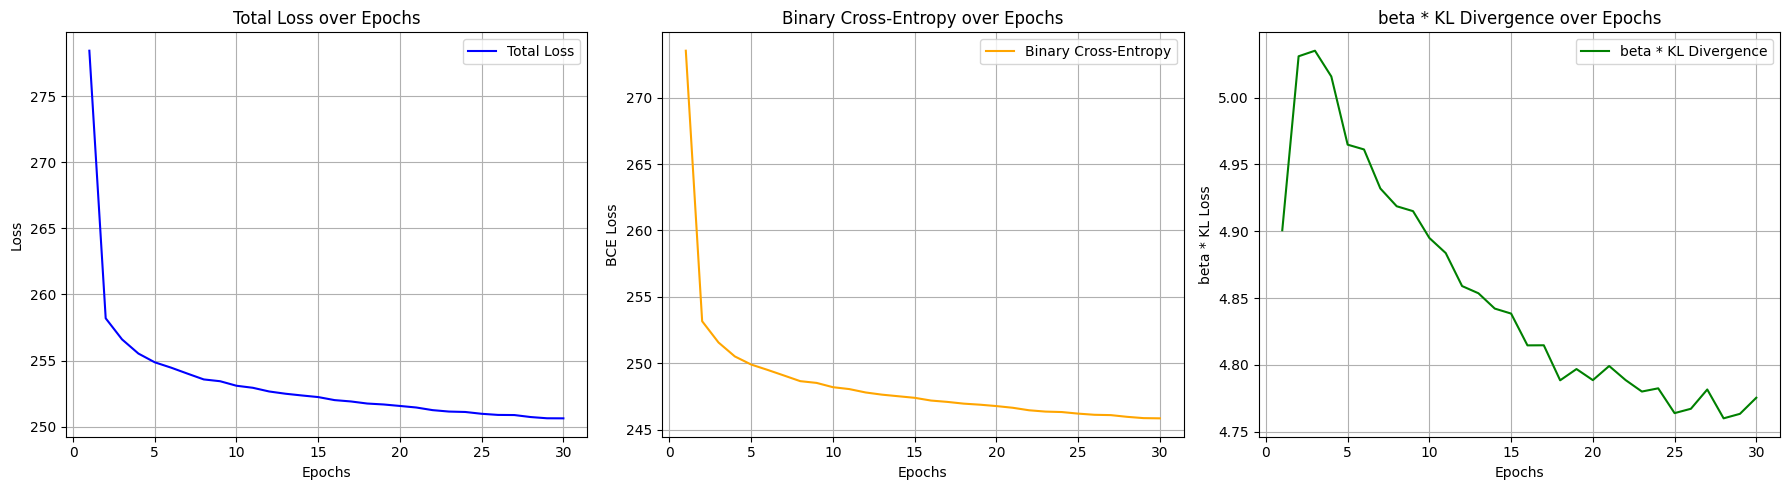

In [56]:
# Premier CVAE avec beta = 1
cvae1 = def_train_cvae(beta = beta_1)

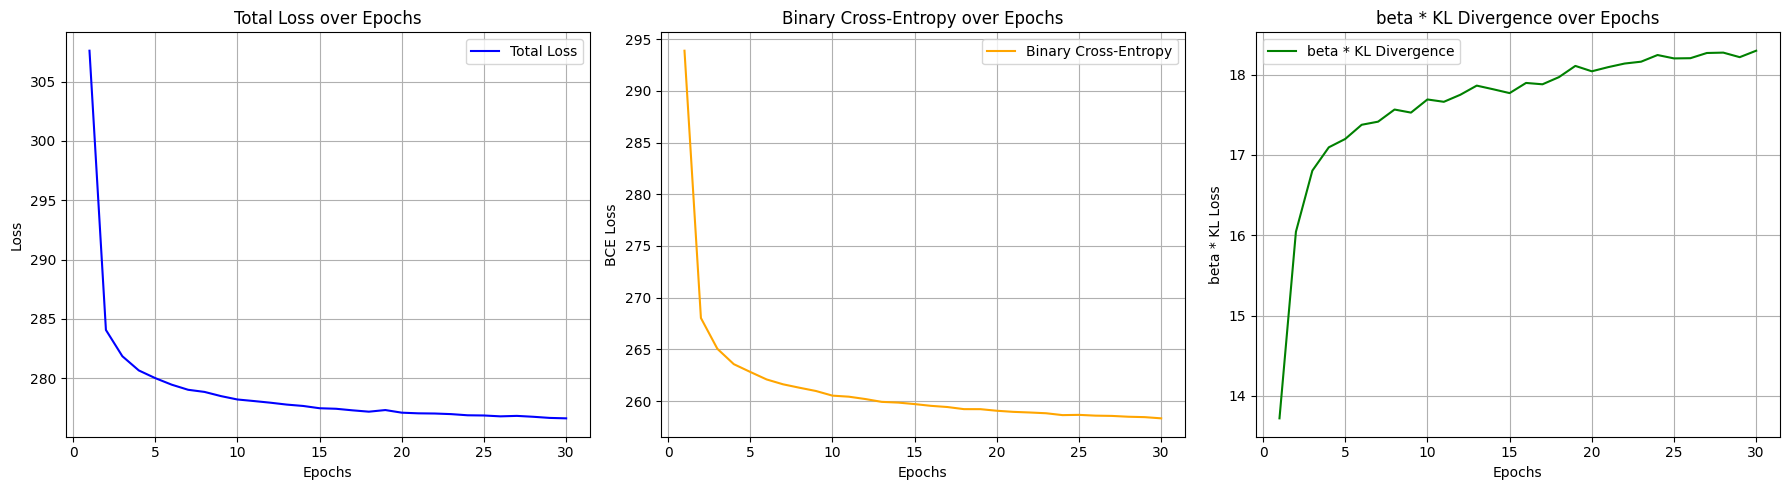

In [57]:
# Deuxième CVAE avec beta = 10
cvae2 = def_train_cvae(beta = beta_2)

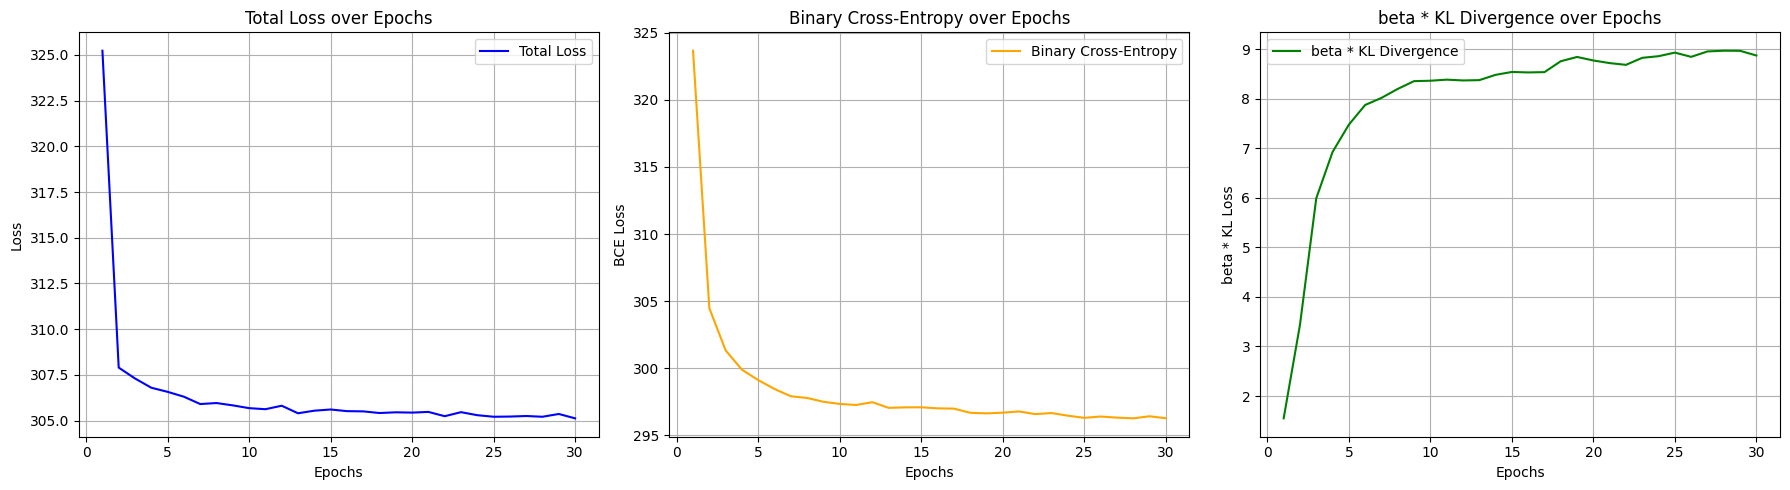

In [58]:
# Troisième CVAE avec beta = 50
cvae3 = def_train_cvae(beta = beta_3)

La loss du premier CVAE (avec $\beta = 1$) est plus faible que les deux autres. De plus, pour les trois modèles, la BCE est celle qui prend le pas sur la loss : elles ont la même tendance, et quasiment la même valeur. En effet, la KL-divergence est plutôt faible (moins de 5 pour le premier  modèle par exemple). Cependant, augmenter le $\beta$ met plus d'importance sur le terme en KL-divergence, donc la BCE est plus élevée : la reconstruction est moins bonne, on met l'accent sur la distribution de l'espace latent. 

In [97]:
def comparison_images(im1, im2, im3, im4, n_images=6):
    fig, ax = plt.subplots(4, n_images, figsize=(25, 10))
    row_labels = ['Original', 'CVAE β=1', 'CVAE β=10', 'CVAE β=50']
    for row in range(4):
        fig.text(0.01, 0.85 - row*0.25, row_labels[row], va='center', rotation=90, size='large')

    for i in range(n_images):
        mse1 = np.mean((im1[i] - im2[i]) ** 2)
        mse2 = np.mean((im1[i] - im3[i]) ** 2)
        mse3 = np.mean((im1[i] - im4[i]) ** 2)
        
        psnr1 = 10 * np.log10(1.0 / mse1)
        psnr2 = 10 * np.log10(1.0 / mse2)
        psnr3 = 10 * np.log10(1.0 / mse3)

        # Plot original images
        ax[0, i].imshow(im1[i], cmap='gray')
        ax[0, i].axis('off')    
        
        # Images reconstruites avec beta = 1
        ax[1, i].imshow(im2[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1,i].set_title(f"MSE : {mse1:.4}, PSNR : {psnr1:.4}")
        
        # Images reconstruites avec beta = 10
        ax[2, i].imshow(im3[i], cmap='gray')
        ax[2, i].axis('off')
    
        ax[2,i].set_title(f"MSE : {mse2:.4}, PSNR : {psnr2:.4}")
        
        # Images reconstruites avec beta = 50
        ax[3, i].imshow(im4[i], cmap='gray')
        ax[3, i].axis('off')
        ax[3,i].set_title(f"MSE : {mse3:.4}, PSNR : {psnr3:.4}")
        
    fig.suptitle("Images originales (haut) vs images reconstruites (bas) pour beta = 1, 10 et 50")
    
    plt.tight_layout()
    plt.show()

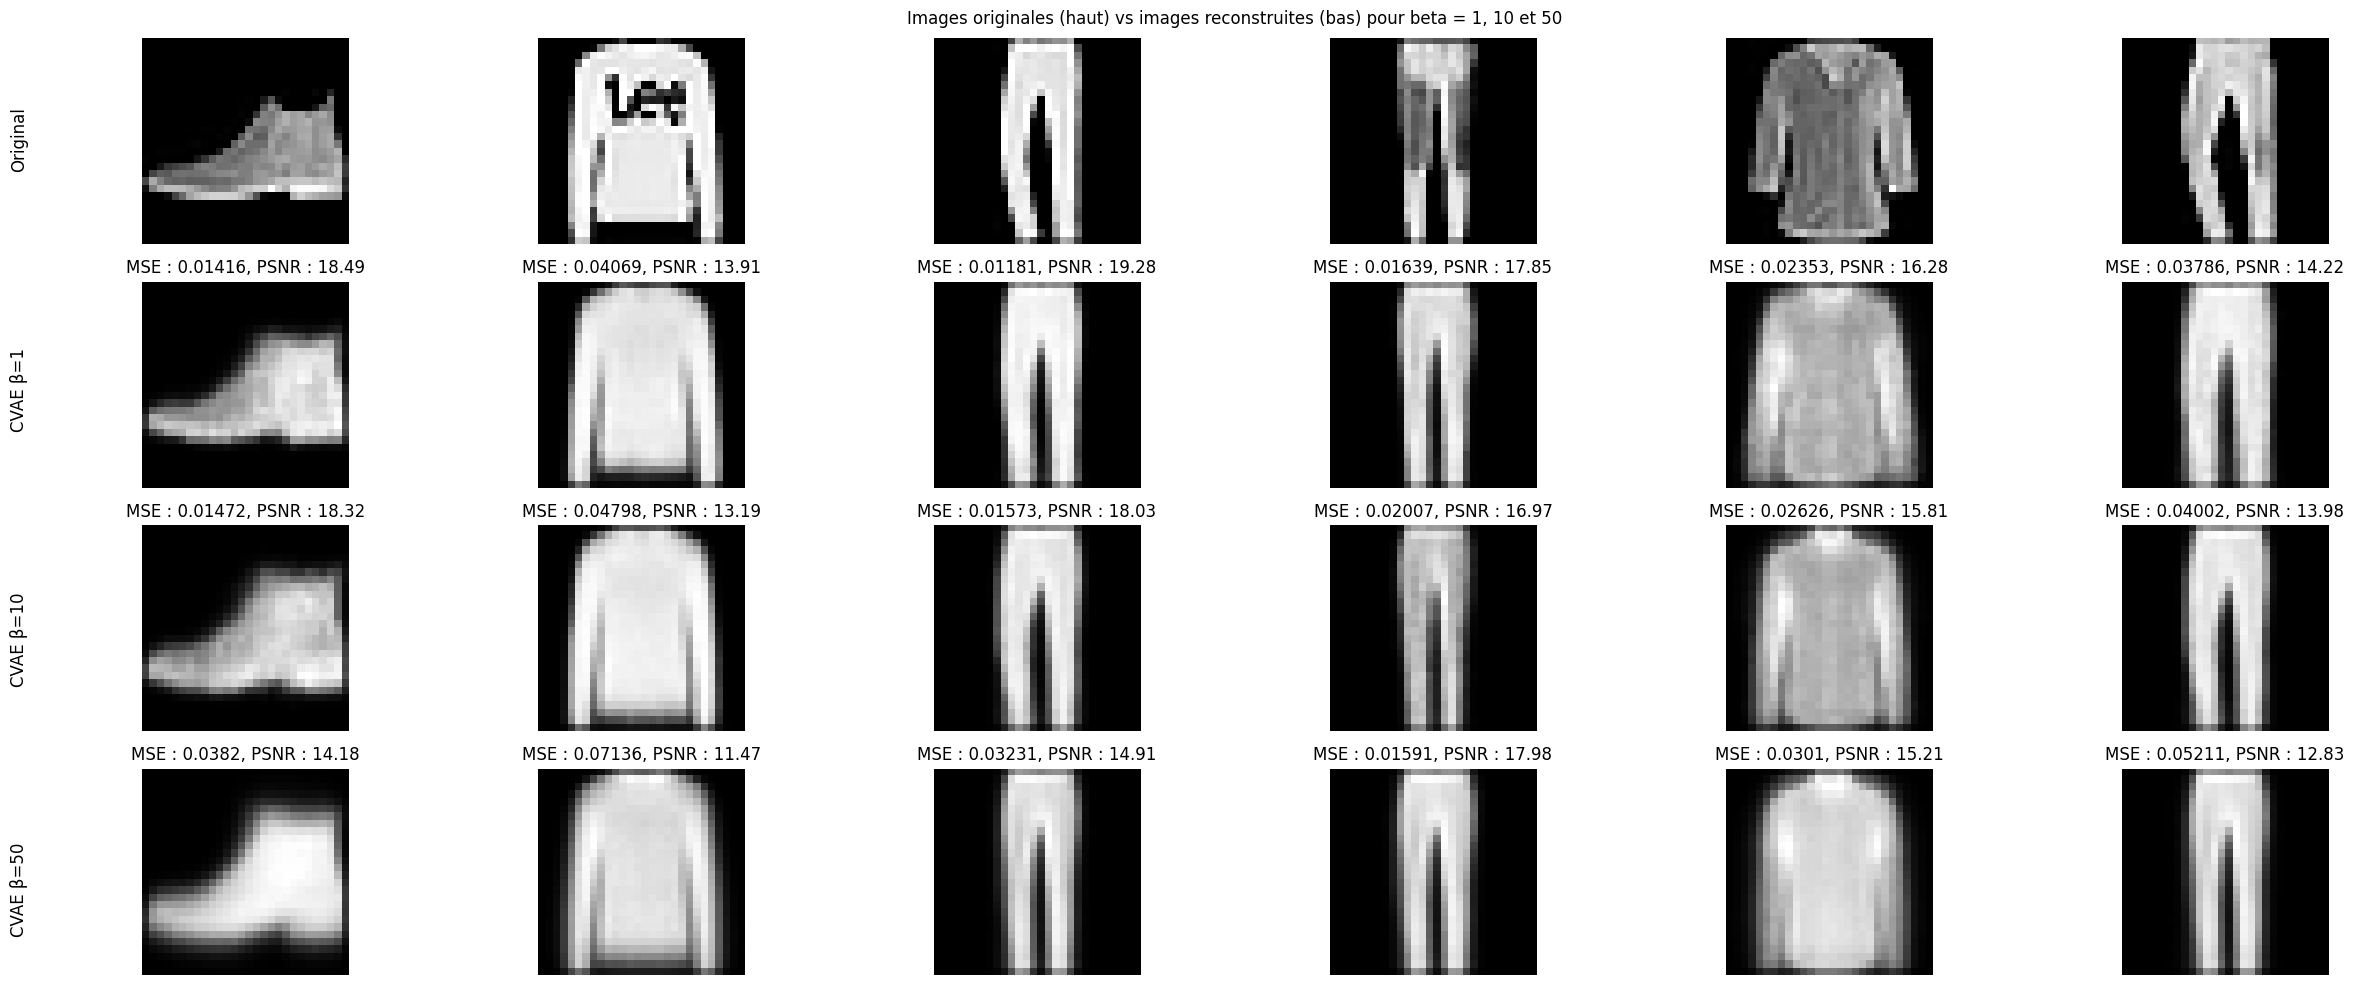

In [98]:
cvae1.eval()
cvae2.eval()
cvae3.eval()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    recons1, _, _ = cvae1(images, labels)
    recons2, _, _ = cvae2(images, labels)
    recons3, _, _ = cvae3(images, labels)

    # Conversion en NumPy pour l'affichage
    images_np = images.cpu().numpy().squeeze(1)
    recons1_np = recons1.cpu().numpy().squeeze(1)
    recons2_np = recons2.cpu().numpy().squeeze(1)
    recons3_np = recons3.cpu().numpy().squeeze(1)

# Affichage
comparison_images(images_np, recons1_np, recons2_np, recons3_np, n_images=6)


Nous pouvons voir la reconstruction des photos par les différents CVAE que nous avons entraîné. Afin d'étudier la validité de la reconstruction, nous utilisons 2 métriques : 
- la MSE (Mean Squared Error) : la somme des carrés des différences $\left( \text{MSE} = \frac{1}{N} \sum_{i=1}^N (X_i - \hat{X}_i)^2 \right)$. Une MSE plus faible indique donc une image reconstruite plus proche de l'image originale.
- le PSNR (Peak Signal to Noise Ratio) : le log en base 10 de la MSE $\left( \text{PSNR} = 10 \log_{10} \left(\frac{1}{MSE} \right) \right)$. Un PSNR plus élevé signifie que l'image reconstruite est plus fidèle à l'image de base.

A l'oeil, et en s'aidant des métriques, on peut voir qu'avec un beta plus faible (1 ou 10) les images sont mieux reconstruites. 

Les réseaux arrivent à reconstruire la forme globale des vêtements, mais pas les détails tels que les écritures ou variations de couleur. 

## Création de 5 échantillons de chaque classe 

In [99]:
num_classes = 10
n_samples = 5
zs = torch.randn(n_samples, latent_dim, device=device)
    
all_generated1 = []
all_generated2 = []
all_generated3 = []

with torch.no_grad():
    for z in zs : 
        z = z.unsqueeze(0).repeat(num_classes, 1)
        labels = torch.arange(num_classes, device = device)
        generated1 = cvae1.decode(z, labels)  # décodage conditionnel
        generated2 = cvae2.decode(z, labels) 
        generated3 = cvae3.decode(z, labels) 
        all_generated1.append(generated1.cpu().numpy())
        all_generated2.append(generated2.cpu().numpy())
        all_generated3.append(generated3.cpu().numpy())
        
all_generated1 = np.concatenate(all_generated1, axis=0)
all_generated1 = all_generated1.squeeze(1)      

all_generated2 = np.concatenate(all_generated2, axis=0)  
all_generated2 = all_generated2.squeeze(1)     

all_generated3 = np.concatenate(all_generated3, axis=0)  
all_generated3 = all_generated3.squeeze(1)       


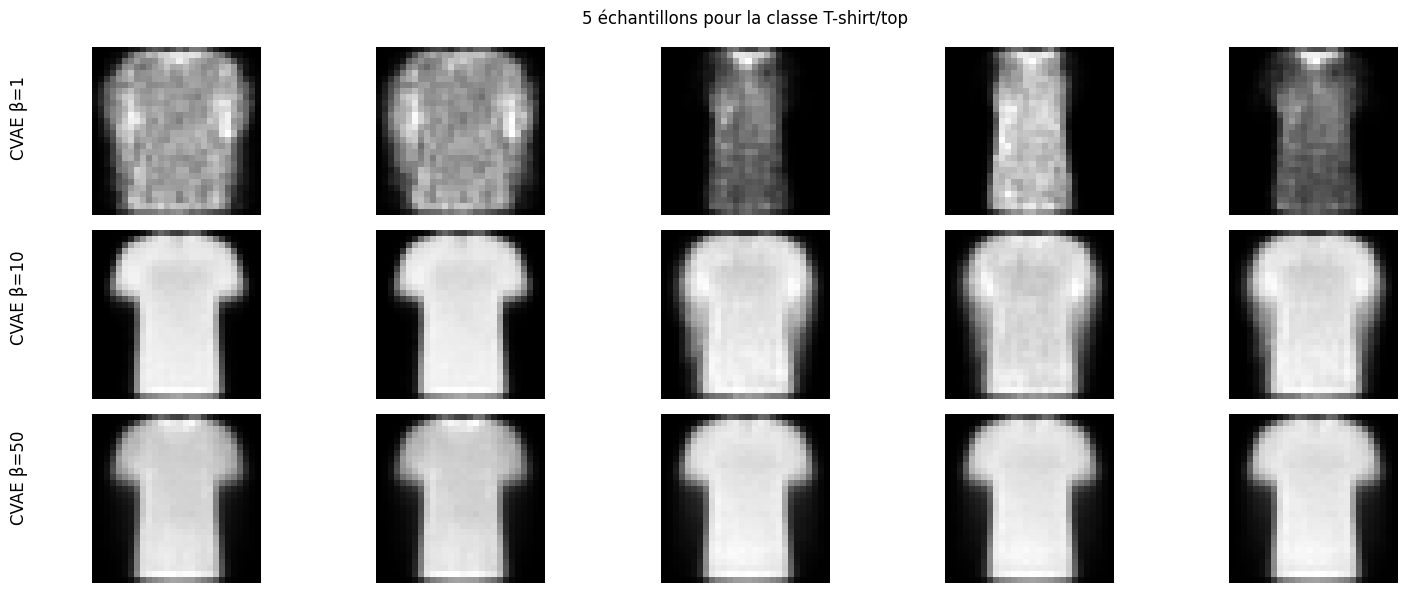

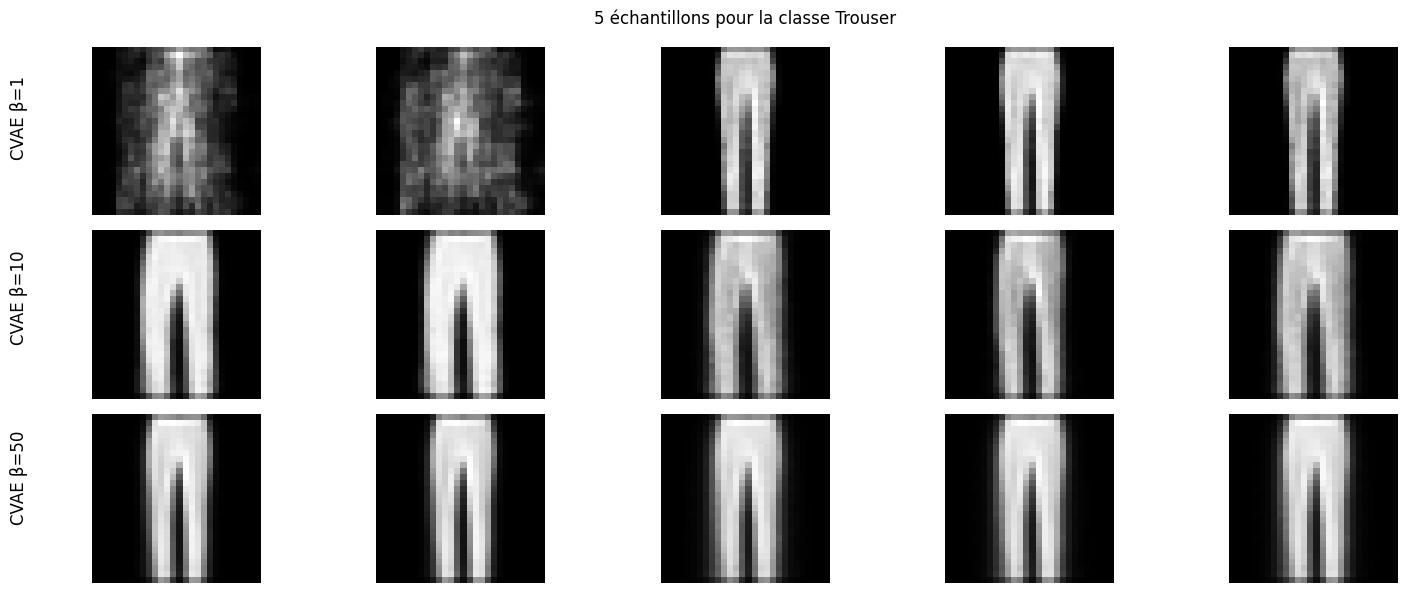

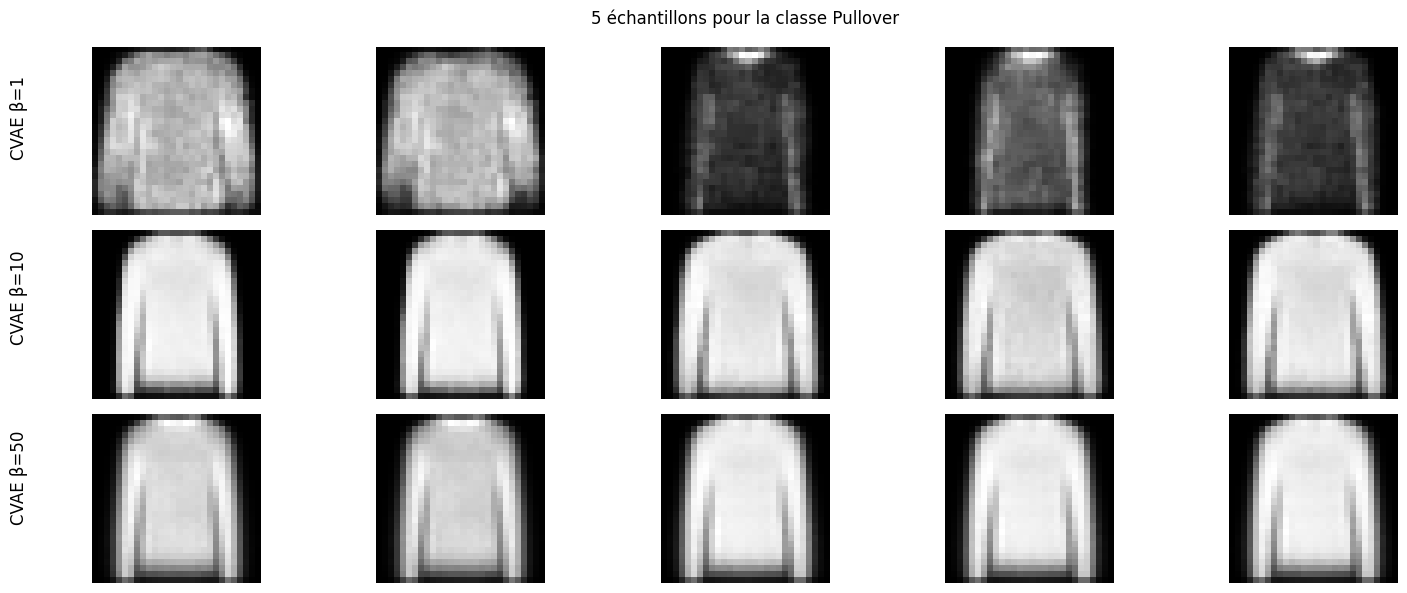

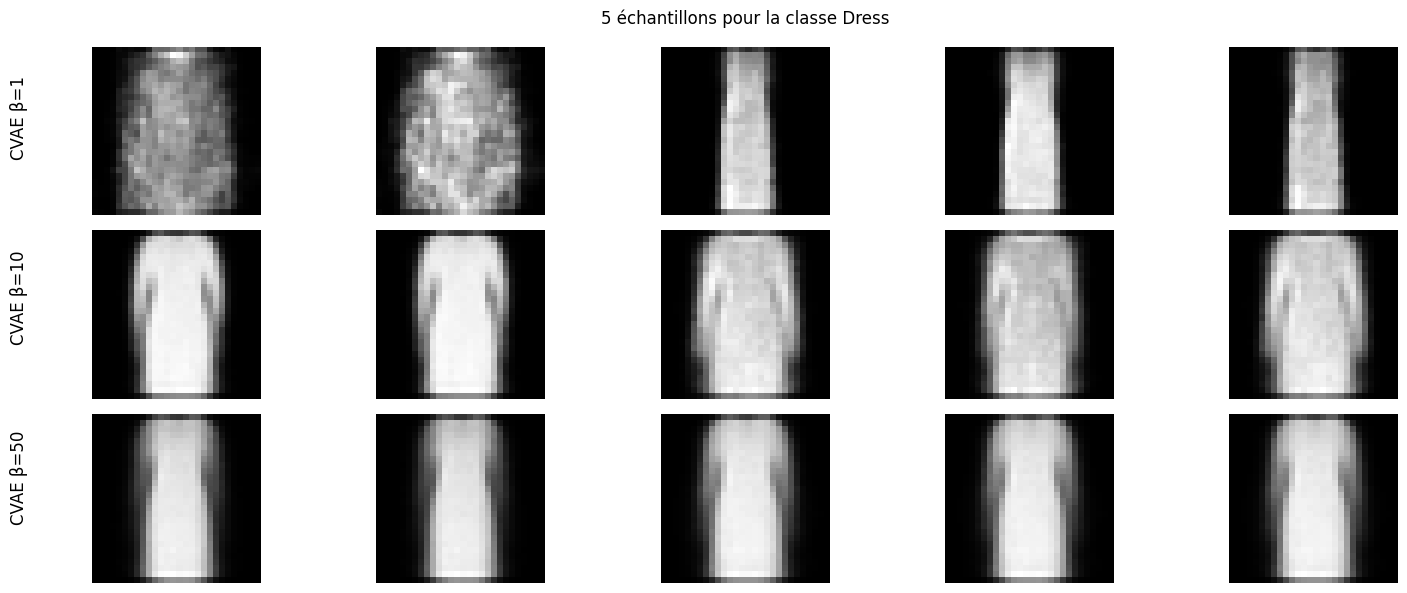

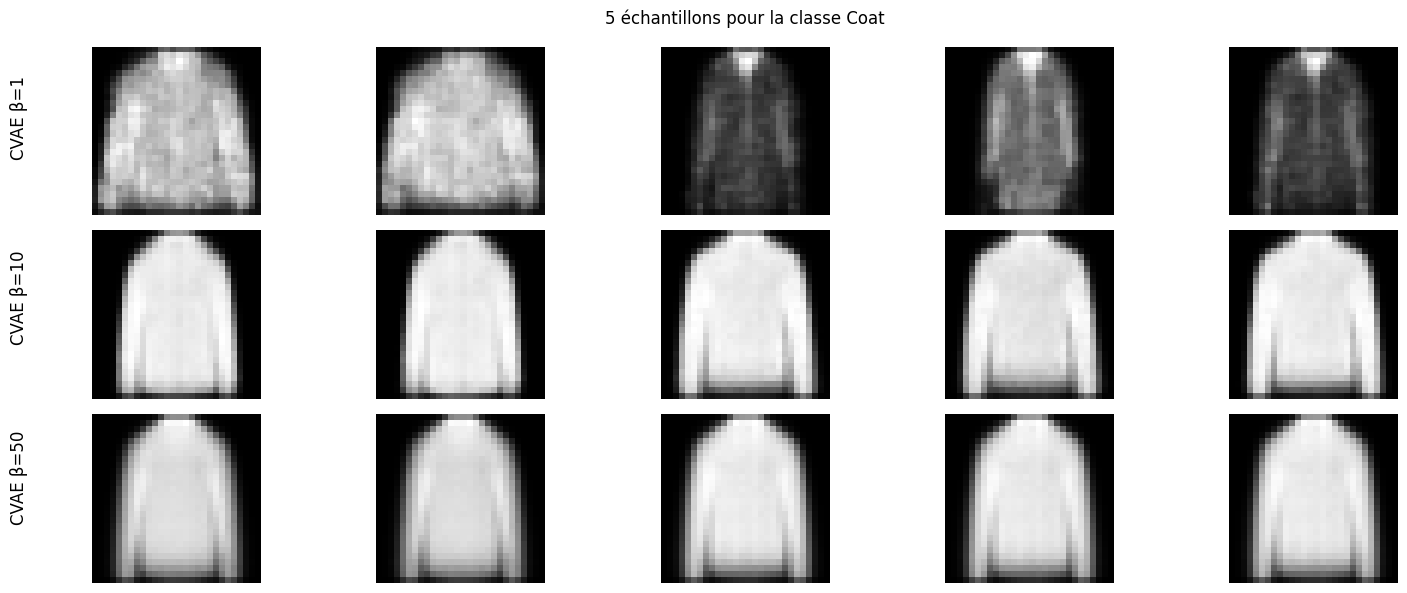

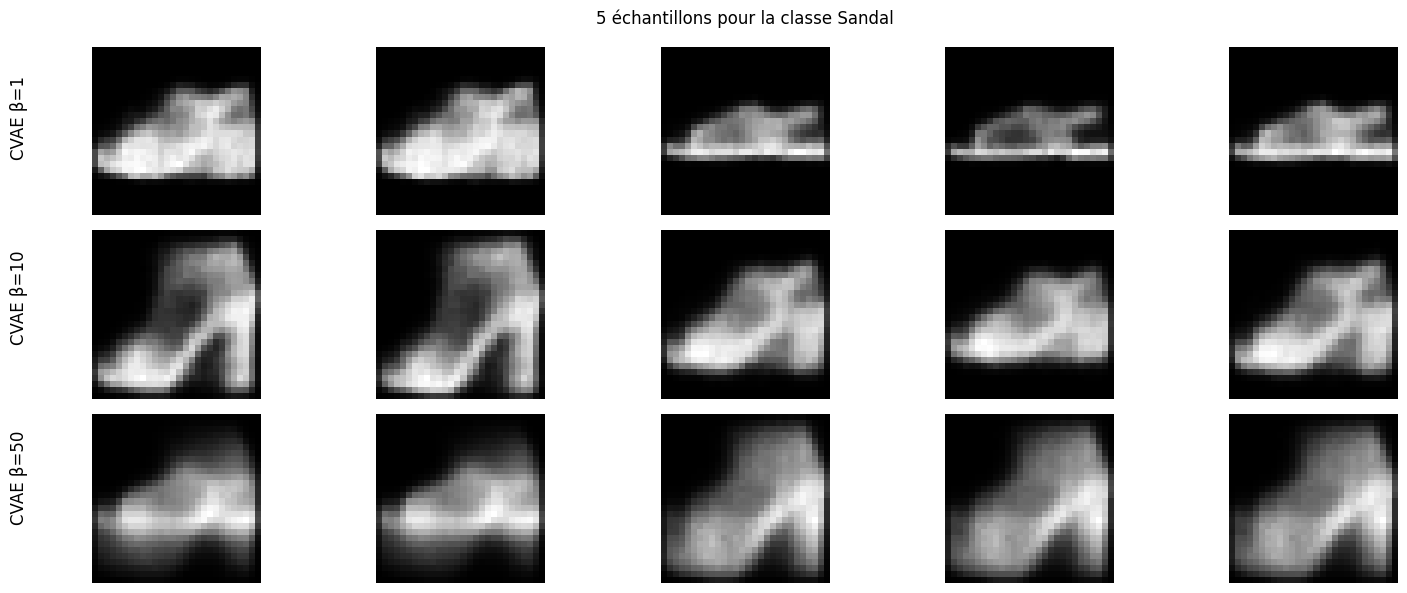

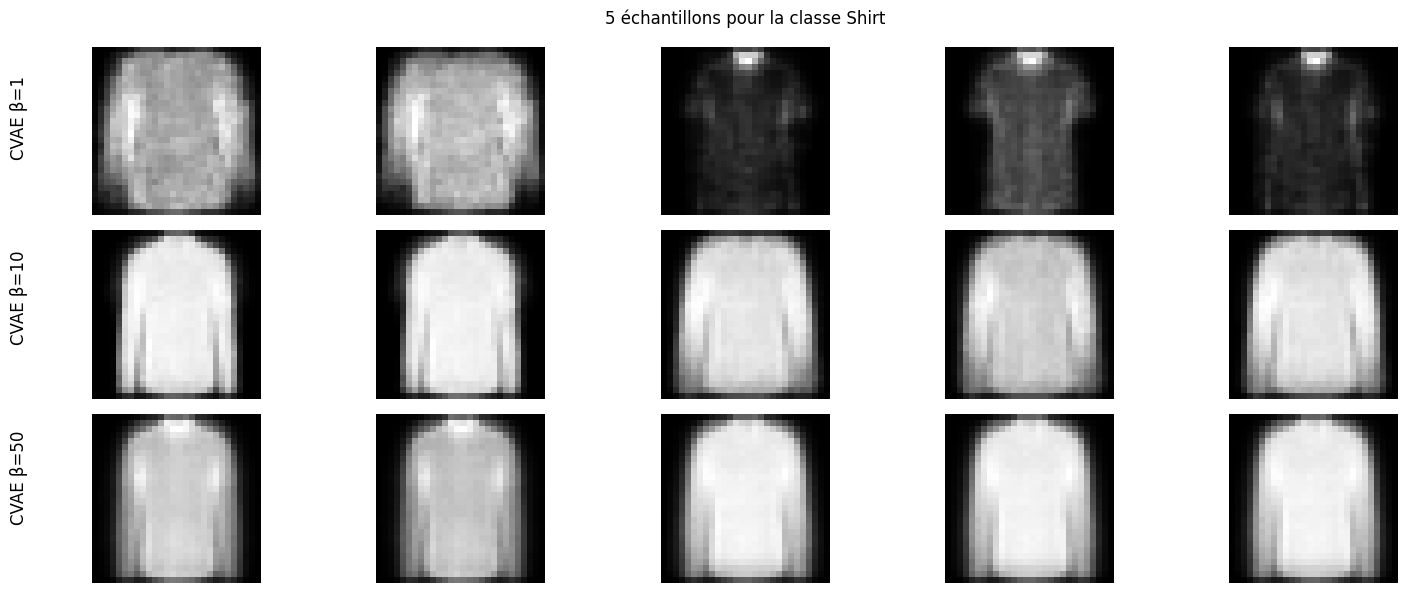

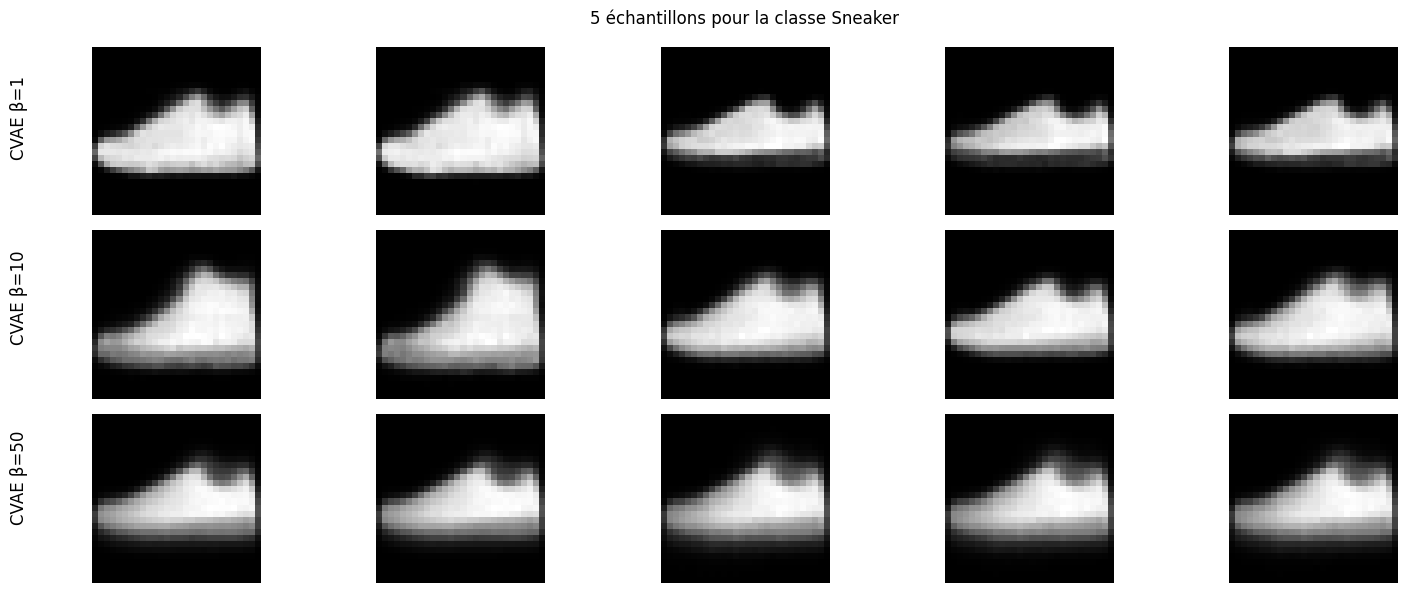

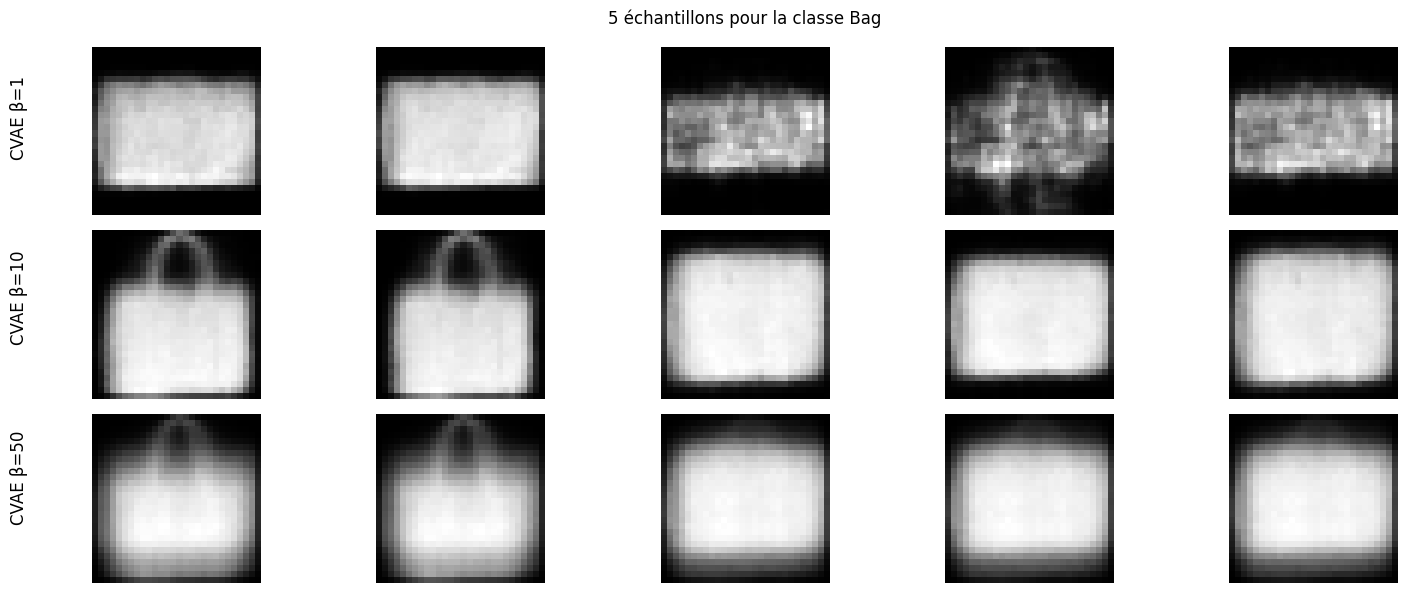

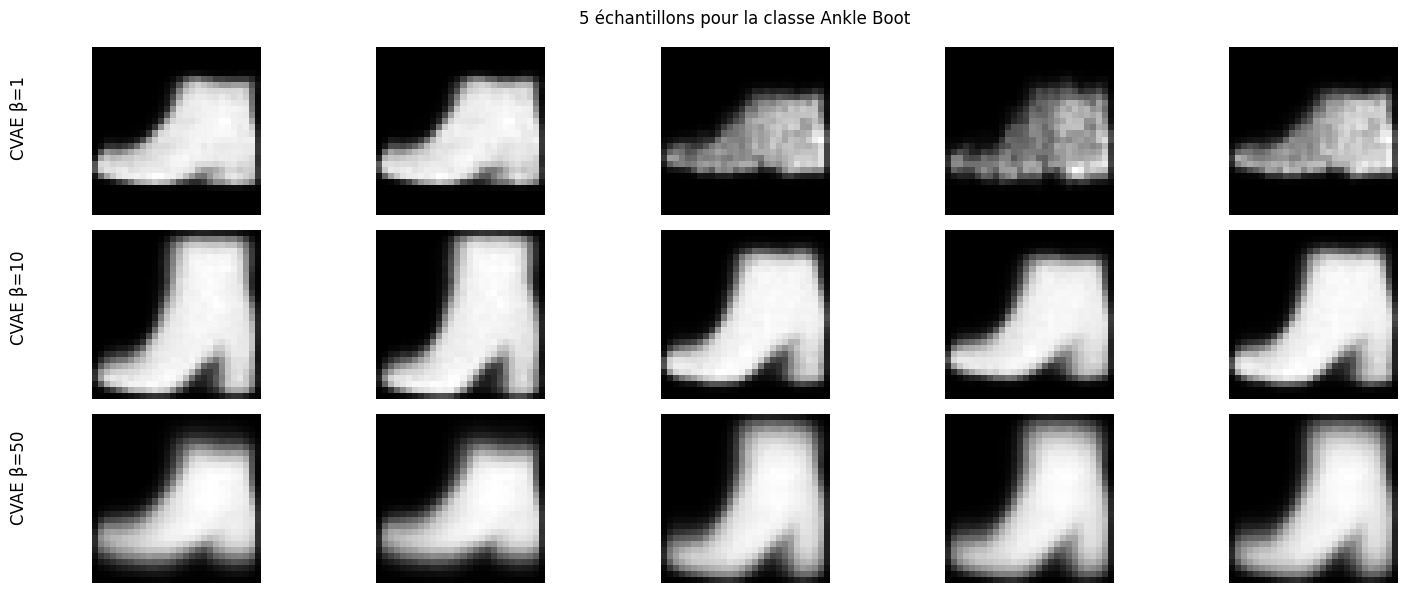

In [105]:
for i in range(num_classes):
    fig, ax = plt.subplots(3, n_samples, figsize=(15, 6))
    row_labels = ['CVAE β=1', 'CVAE β=10', 'CVAE β=50']
    for row in range(3):
        fig.text(0.01, 0.8 - row*0.3, row_labels[row], va='center', rotation=90, size='large')

    for j in range(n_samples):     # colonne = classe
        idx = j * num_classes + i
        ax[0, j].imshow(all_generated1[idx], cmap='gray')
        ax[0, j].axis('off')
        
        ax[1, j].imshow(all_generated2[idx], cmap='gray')
        ax[1, j].axis('off')
        
        ax[2, j].imshow(all_generated3[idx], cmap='gray')
        ax[2, j].axis('off')
        fig.suptitle(f"{n_samples} échantillons pour la classe {classes[i]}")
    plt.tight_layout()
    plt.show()

Nous avons pris les 5 mêmes échantillons de l'espace latent pour reconstruire les images de chaque classe. La première ligne correspond au CVAE avec $\beta = 1$, la deuxième ligne pour $\beta = 10$ et la troisième pour $\beta = 50$.

Les trois lignes reconstruisent globalement des images dans le même style (par exemple pour les chaussures, des t-shirts à manche longue, même forme de sac...). 
Pour $\beta = 1$, le CVAE a tendance à construire des images très sombres, où on distingue parfois peu l'objet. La forme n'est pas très détaillée (en particulier pour les pulls ou les robes). 
Pour $\beta = 50$, les images créées se ressemblent beaucoup : les vêtements ont la même forme, malgré des échantillons différents. De plus, les contours sont très flous ce qui rend le vêtement peu distinguable. 
Pour $\beta = 10$, les images ressemblent à celles créées par le CVAE avec $\beta = 50$. Par exemple, les sacs ont la même forme pour un même échantillon, alors que le premier réseau avec $\beta = 1$ produit des sacs de formes différentes. 

Comme la dimension de l'espace latent du modèle est de 2, on peut le visualiser pour les trois réseaux.

In [106]:
def plot_latent_space(model, zs):
    model.eval()
    latents = []
    labels_list = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            mu, _ = model.encode(data, labels)
            latents.append(mu.cpu())
            labels_list.append(labels.cpu())

    latents = torch.cat(latents, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    # Scatter par classe
    for i in range(10):
        idxs = labels_list == i
        plt.scatter(latents[idxs, 0], latents[idxs, 1], label=classes[i], alpha=0.5)


    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(f"Représentation de l'espace latent du modèle")
    plt.legend()
    plt.show()


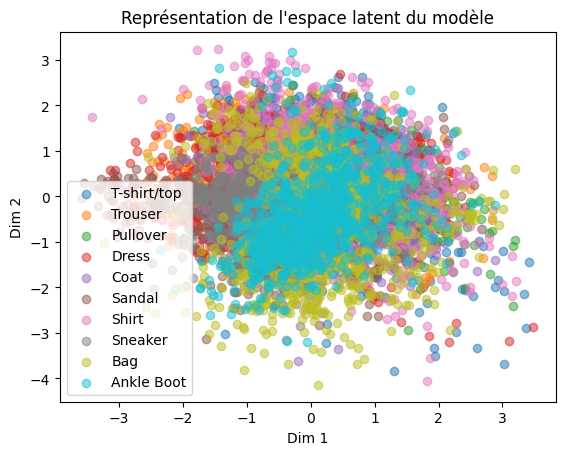

In [107]:
plot_latent_space(cvae1, zs)

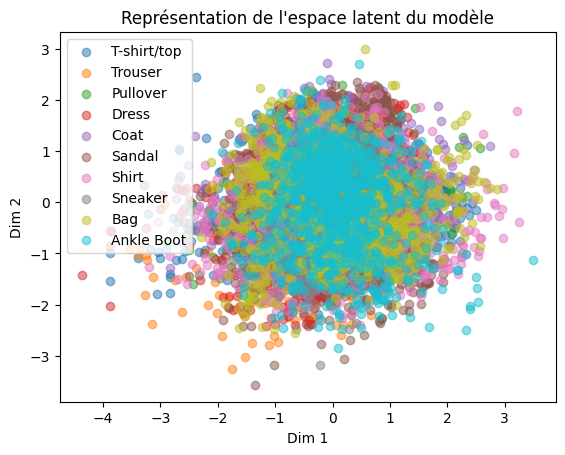

In [108]:
plot_latent_space(cvae2, zs)

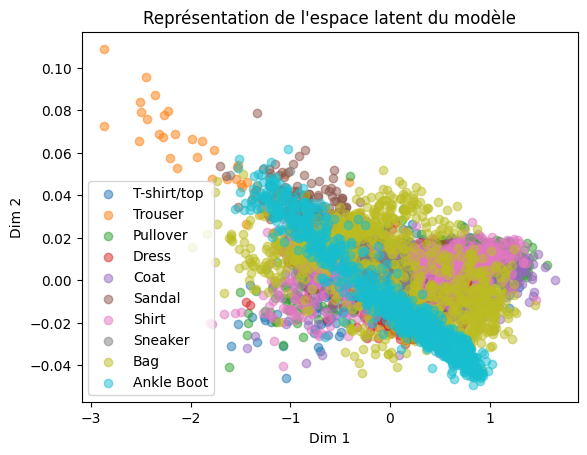

In [109]:
plot_latent_space(cvae3, zs)

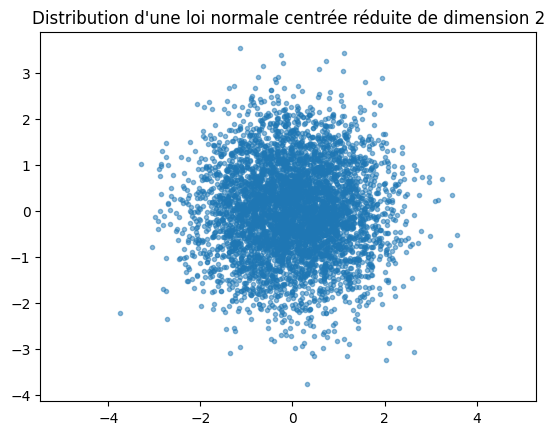

In [111]:
z = np.random.multivariate_normal((0, 0), np.diag([1,1]), 5000) 
plt.plot(z[:, 0], z[:, 1], '.', alpha=0.5)
plt.axis('equal')
plt.title("Distribution d'une loi normale centrée réduite de dimension 2")
plt.show()

La distribution de l'espace latent est censée ressembler à la distribution d'une loi normale $\mathcal{N}(0, I_2)$, qui peut être visualisée sur le dernier graphe. Ainsi, pour un $\beta$ plus faible (1 ou 10), les espaces latents ont la même forme que la distribution de lois normales centrées réduites. Cependant, pour un $\beta$ plus grand, le nuage de points obtenus est très allongé, bien différent d'une $\mathcal{N}(0, I_2)$. Pour un $\beta = 10$, les distributions de chaque classes sont plus confondues que pour $\beta = 1$. Pour ce dernier, la distribution des classes est bien plus distincte. 

Ainsi, le réseau avec $\beta = 10$ semble être le meilleur compromis. Les images sont bien reconstruites, celles créées sont simples mais plus lisibles que pour les deux autres réseaux, et la distribution de l'espace latent est celle qui ressemble le plus à une  $\mathcal{N}(0, I_2)$.

# Autres test

Nous avons rapidement testé avec une stratégie d'embedding plutot que de hot-one. Le code ci-dessous a été utilisé :

In [ ]:
class ConditionalVAEEmbedding(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10, embedding_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )

        self.flatten_size = 128 * 4 * 4

        # Conditional embedding
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # Latent space (with concatenated condition)
        self.fc_mu = nn.Linear(self.flatten_size + embedding_dim, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size + embedding_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + embedding_dim, 4 * 4 * 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.label_embedding(c)
        # Concatenate condition with encoded input
        x = torch.cat([x, c], dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        c = self.label_embedding(c)
        # Concatenate condition with latent vector
        z = torch.cat([z, c], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.sample(mu, log_var)
        return self.decode(z, c), mu, log_var

Comme il y a peu de classes, les résultats obtenus sont globalement les mêms. Cependant, l'impact du paramètre $\beta$ est légèrement différent (meilleure reconstruction un petit $\beta$, moins bonne pour un grand $\beta$). Cependant, $\beta = 10$ semble être le meilleur compromis, avec des résultats très similaires à ceux montrés. 

# Sources

https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#cvae et https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf (forme de la fonction perte) : compréhension du VAE et CVAE


https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb/ : structure de l'encodeur et du décodeur, utiliser une stratégie de concatenate plutôt que additive

Conditional Variational Autoencoders (SID 2025) et https://medium.com/data-science/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a : utilisation de hot-one vs embeddings